In [2]:
import numpy as np
from numpy import sin, pi
import matplotlib.pyplot as plt
import scipy.stats
from ultranest import ReactiveNestedSampler
from ultranest.plot import cornerplot
import pandas as pd
from scipy.integrate import odeint
from datetime import datetime

#----------------------MODELO----------------------#

def b(t,b0,b1,b2,b3,t1,t2,t3):
    if t<=t1:
        b=b0
    elif t2>=t>t1:
        b=b1
    elif t3>=t>t2:
        b=b2
    elif t>t3:
        b=b3
    return b

def a(t,a0,a1,a2,a3,t1, t2,t3):
    if t<=t1:
        a=a0
    elif t2>=t>t1:
        a=a1
    elif t3>=t>t2:
        a=a2
    elif t>t3:
        a=a3
    return a

def SIR(f,t,params):
    b0,b1,b2,b3,a0,a1,a2,a3,t1,t2,t3,g = params
    #variables
    S = f[0]
    I = f[1]
    R = f[2]
    Nc = f[3]
    #equations inclunding epidemic curve
    dS_dt = -(b(t,b0,b1,b2,b3,t1,t2,t3))*I*(S/N)*(S/N)**(1/(a(t,a0,a1,a2,a3,t1, t2,t3)))
    dI_dt = (b(t,b0,b1,b2,b3,t1,t2,t3))*I*(S/N)*(S/N)**(1/(a(t,a0,a1,a2,a3,t1, t2,t3))) - g*I 
    dR_dt = g*I

    
    #new cases rate
    dNc_dt = (b(t,b0,b1,b2,b3,t1,t2,t3))*I*(S/N)*(S/N)**(1/a(t,a0,a1,a2,a3,t1, t2,t3))
    
    return [dS_dt,dI_dt,dR_dt,dNc_dt]


#----------------------INTEGRADOR----------------------#
def function(params,ts0):
    
    
    b0,b1,b2,b3,a0,a1,a2,a3,t1,t2,t3,g,i0,rr = params
    q0 = [N-i0,i0,0,0]
    parode = b0,b1,b2,b3,a0,a1,a2,a3,t1,t2,t3,g
   
    qs = odeint(SIR,q0, ts0,args=(parode,),mxstep=1000000)
    qi = rr*qs[:,-1]
    return qi


#----------------------LOGLIKELIHOOD----------------------#
def log_likelihood(params):
    # unpack the current parameters:
    b0,b1,b2,b3,a0,a1,a2,a3,t1,t2,t3,g,i0,rr = params
    # compute for each x point, where it should lie in y
    y_model = function(params,ts0)
    # compute likelihood
    loglike = -0.5 * (((y_model - data) / yerr)**2).sum()

    return loglike
parameters = ['b0','b1','b2','b3','a0','a1','a2','a3','t1','t2','t3', 'g','i0','rr']

#----------------------PARAMETROS----------------------#
def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let b go from 0 to 2
    params[0] = cube[0]*2 #b0
    params[1] = cube[1]*2 #b1
    params[2] = cube[2]*2 #b2
    params[3] = cube[3]*2 #b3
    # let a go from 0,01 to 1
    params[4] =  cube[4]*99 + 1 #a0
    params[5] =  cube[5]*99 + 1 #a1
    params[6] =  cube[6]*99 + 1 #a2
    params[7] =  cube[7]*99 + 1 #a3
    # let t go from 0 to ts0
    params[8] = cube[8]*ts/3
    params[9] = cube[9]*ts/3 + ts*1/3
    params[10] = cube[10]*ts/3 +ts*2/3
    # let g go from 1/5 to 1/3
    params[11] = cube[11]*2/15+1/5
    # let i0 go from 0 to 25
    params[12] = cube[12]*25
    # Let RR go from 0.15 to 0.25
    params[13] = cube[13]/10 + 0.15

    return params

In [3]:
s = 'BA'
data_frame=pd.read_csv('Best_Fits_'+s+'.csv')
a0=data_frame.a0.values
a1=data_frame.a1.values
a2=data_frame.a2.values
a3=data_frame.a3.values
b0=data_frame.b0.values
b1=data_frame.b1.values
b2=data_frame.b2.values
b3=data_frame.b3.values
t1=data_frame.t1.values
t2=data_frame.t2.values
t3=data_frame.t3.values
g=data_frame.g.values
i0=data_frame.i0.values
subn=data_frame.subn.values

a0=a0[0]
a1=a1[0]
a2=a2[0]
a3=a3[0]
b0=b0[0]
b1=b1[0]
b2=b2[0]
b3=b3[0]
t1=t1[0]
t2=t2[0]
t3=t3[0]
g=g[0]
i0=i0[0]
subn=subn[0]

209


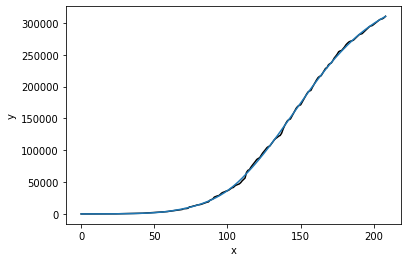

In [4]:
#----------------------DADOS----------------------#
s='BA'
file='estado'
N=14930634
df=pd.read_csv('Data/'+s+"/"+file+".csv")
df = df.query("date <= '2020-09-30'")
dates=df.date.values
data=df.cases.values
ts0=np.arange(len(data))
ts = len(data)
yerr = 1.

#----------------------PLOT DADOS----------------------#


%matplotlib inline
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
#plt.errorbar(x=ts0, y=data, yerr=yerr,marker='o', ls=' ', color='k');
plt.plot(ts0,data, color='k')
print(ts)
plt.plot(ts0,function([a0/(b0),a1/(b1),a2/(b2),a3/(b3),a0,a1,a2,a3,t1,t2,t3,g,i0,subn],ts0))

In [5]:
def kappa(t,a0,a1,a2,a3,t1, t2,t3):
    if t<=t1:
        kappa=a0
    elif t2>=t>t1:
        kappa=a1
    elif t3>=t>t2:
        kappa=a2
    elif t>t3:
        kappa=a3
    return kappa

def nu(t,b0,b1,b2,b3,t1,t2,t3):
    if t<=t1:
        nu=b0
    elif t2>=t>t1:
        nu=b1
    elif t3>=t>t2:
        nu=b2
    elif t>t3:
        nu=b3
    return nu

def SIRH(f,t,parametros):
    #parameters
    a0,a1,a2,a3,b0,b1,b2,b3,t1,t2,t3, g = parametros
    #variables
    S = f[0]
    I = f[1]
    R = f[2]
    Nc = f[3]
    #equations inclunding epidemic curve
    dS_dt = -kappa(t,a0,a1,a2,a3,t1,t2,t3)*(S/N)**(1+1/kappa(t,a0,a1,a2,a3,t1,t2,t3))*I/(nu(t,b0,b1,b2,b3,t1,t2,t3))
    dI_dt = kappa(t,a0,a1,a2,a3,t1,t2,t3)*(S/N)**(1+1/kappa(t,a0,a1,a2,a3,t1,t2,t3))*I/(nu(t,b0,b1,b2,b3,t1,t2,t3)) - g*I 
    dR_dt = g*I

    
    #new cases rate
    dNc_dt = kappa(t,a0,a1,a2,a3,t1, t2,t3)*(S/N)**(1+1/kappa(t,a0,a1,a2,a3,t1, t2,t3))*I/(nu(t,b0,b1,b2,b3,t1,t2,t3))
    
    return [dS_dt,dI_dt,dR_dt,dNc_dt]

In [6]:
ts0=np.arange(len(data))
q0 = [N-i0,i0,0,0]
#parameters
parode = a0, a1,a2,a3,b0,b1,b2,b3,t1,t2,t3,g
#calls integrator
qs = odeint(SIRH,q0, ts0,args=(parode,),mxstep=1000000)

qi = subn*qs[:,-1]

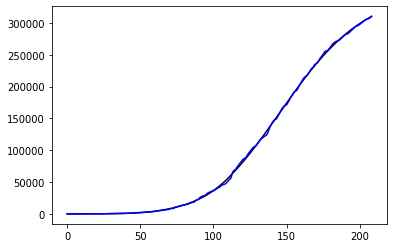

In [7]:
plt.plot(ts0,qi, color='k')
plt.plot(ts0,data, color='b')

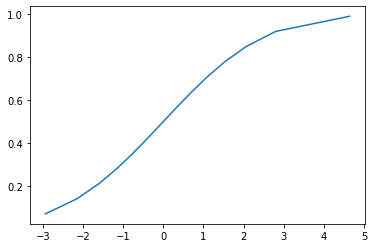

In [15]:
x = np.linspace(0,7,100)
y = scipy.stats.norm.ppf(x, 0, 2)
plt.plot(y,x)